In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
labels_path = "../data/labels/"
imgs_path = "../data/sat_imgs/"

In [3]:
for i in range(100) :
    mask = np.load(f"{labels_path}/{i}.npy")
    mask = np.where(mask >= 35, 1, 0)
    print(mask.sum())

2096
869
12346
11251
47522
74256
24249
4682
31888
20729
19349
39056
20574
8416
24797
48753
27624
70538
37996
47257
14746
55727
45131
53690
33050
48688
19792
12055
82377
73866
41026
30872
49445
29101
65617
32406
25584
50585
46898
8674
12828
83832
77567
37473
30909
26553
17693
27965
22125
39308
44014
67193
36097
58038
71479
55515
37128
51241
52426
55431
45231
45135
32786
23709
15097
15071
23537
30352
33544
48879
34684
51626
33598
5348
8779
27665
8239
15944
15624
28082
36169
21522
23270
33737
20062
8870
7033
13854
33579
4402
10144
13792
26391
16228
11119
14941
31702
32203
27479
15338


In [4]:
label = np.load(labels_path + "/0.npy")
img = np.load(imgs_path + "/0.npy")
# img = np.load("tmp.npy")

In [5]:
img.shape

(523, 500, 13)

In [6]:
img[..., 0 : 3] /= 255

In [7]:
img_rgb = img[..., [2,1,0]]

In [8]:
img_rgb = img_rgb.astype(int)

In [9]:
ndvi = img[..., -1]
ndvi = np.clip(ndvi, -1, 1)

In [10]:
mask = np.where(label >= 35, 1, 0)

In [11]:
m = np.reshape(mask, (mask.shape[1], mask.shape[2], 1))

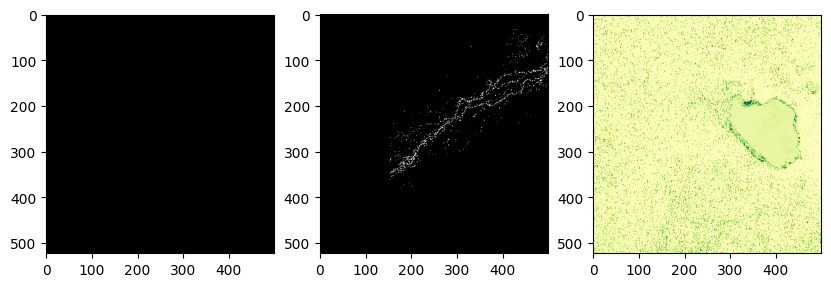

In [14]:
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_rgb * 3)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(m, cmap = 'gray')
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(ndvi, cmap = 'RdYlGn')


In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms
from scipy.ndimage import zoom
from tqdm import tqdm
import os
import re


In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [10]:
class CustomDataset(Dataset):
    def __init__(self, image_files, labels_folder, target_size = (512, 512), transform=None):
        self.image_files = image_files
        self.labels_folder = labels_folder
        self.transform = transform
        self.target_size = target_size
#         self.image_files = os.listdir(images_folder)
#         self.label_files = os.listdir(labels_folder)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):

        image_path = self.image_files[idx]
        match = re.search(r'(\d+)', image_path)        
        data_id = match.group(1)
        label_path = os.path.join(self.labels_folder, data_id + '.npy')

        image = np.load(image_path)
        label = np.load(label_path)
        image = image.astype(np.float32)
        mask = np.where(label >= 35, 1, 0)
        mask = np.reshape(mask, (mask.shape[1], mask.shape[2], 1))
        
        image = self.interpolate(image, self.target_size)
        mask = self.interpolate(mask, self.target_size)
        image[..., 0 : 3] /= 255
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask
    
    def interpolate(self, array, target_size):
        zoom_factors = [target_size[i] / array.shape[i] for i in range(2)]
        zoom_factors.append(1)
        
        interpolated_array = zoom(array, zoom_factors, order=1, mode='nearest')

        return interpolated_array


In [11]:
images_folder = "../data/sat_imgs/"
labels_folder = "../data/labels/"

In [12]:
image_files = os.listdir(images_folder)
image_files = [os.path.join(images_folder, file) for file in image_files]
train_files, test_files = train_test_split(image_files, test_size=0.3, random_state=42)

In [13]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CustomDataset(train_files, labels_folder, transform=transform)
test_dataset = CustomDataset(test_files, labels_folder, transform=transform)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [15]:
for batch in train_loader:
    tmp_img = batch[0]
    tmp_mask = batch[1]
    break

In [16]:
tmp_img.shape, tmp_mask.shape

(torch.Size([1, 13, 512, 512]), torch.Size([1, 1, 512, 512]))

In [17]:
in_channels = 13  
out_channels = 1  
model = UNet(in_channels, out_channels)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model.to(device)

UNet(
  (encoder): Sequential(
    (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode=bilinear)
  )
)

In [20]:
csv_file_path = 'training_metrics.csv'
fieldnames = ['Epoch', 'Train_Loss', 'Train_Accuracy', 'Val_Loss', 'Val_Accuracy']
if not os.path.exists(csv_file_path):
    with open(csv_file_path, 'w', newline='') as csvfile:
        csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        csv_writer.writeheader()

In [21]:
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    train_predictions = []
    train_labels = []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        labels = labels.float()

        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
        train_predictions.extend(predicted_labels.cpu().numpy().flatten())
        train_labels.extend(labels.cpu().numpy().flatten())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_accuracy = accuracy_score(train_labels, train_predictions)

    model.eval()
    total_val_loss = 0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            labels = labels.float()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
            val_predictions.extend(predicted_labels.cpu().numpy().flatten())
            val_labels.extend(labels.cpu().numpy().flatten())

    val_accuracy = accuracy_score(val_labels, val_predictions)

    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {total_train_loss / len(train_loader)} - Train Accuracy: {train_accuracy}")
    print(f"Epoch {epoch + 1}/{epochs} - Val Loss: {total_val_loss / len(test_loader)} - Val Accuracy: {val_accuracy}")

    with open(csv_file_path, 'a', newline='') as csvfile:
        csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        csv_writer.writerow({'Epoch': epoch + 1, 'Train_Loss': total_train_loss / len(train_loader),
                             'Train_Accuracy': train_accuracy, 'Val_Loss': total_val_loss / len(test_loader),
                             'Val_Accuracy': val_accuracy})

Epoch 1/3: 100%|████████████████████████████████████████████████████████████████████████| 70/70 [00:44<00:00,  1.56it/s]


Epoch 1/3 - Train Loss: 0.6931472420692444 - Train Accuracy: 0.8785368238176618
Epoch 1/3 - Val Loss: 0.6931472420692444 - Val Accuracy: 0.8873196919759114


Epoch 2/3: 100%|████████████████████████████████████████████████████████████████████████| 70/70 [00:43<00:00,  1.61it/s]


Epoch 2/3 - Train Loss: 0.6931472420692444 - Train Accuracy: 0.8785368238176618
Epoch 2/3 - Val Loss: 0.6931472420692444 - Val Accuracy: 0.8873196919759114


Epoch 3/3: 100%|████████████████████████████████████████████████████████████████████████| 70/70 [00:43<00:00,  1.63it/s]


Epoch 3/3 - Train Loss: 0.6931472420692444 - Train Accuracy: 0.8785368238176618
Epoch 3/3 - Val Loss: 0.6931472420692444 - Val Accuracy: 0.8873196919759114


In [22]:
torch.save(model.state_dict(), 'unet_model.pth')

In [23]:
model.eval()

UNet(
  (encoder): Sequential(
    (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode=bilinear)
  )
)

In [27]:
def interpolate(array, target_size):
    zoom_factors = [target_size[i] / array.shape[i] for i in range(2)]
    zoom_factors.append(1)

    interpolated_array = zoom(array, zoom_factors, order=1, mode='nearest')

    return interpolated_array

In [37]:
im = np.load("../data/sat_imgs/99.npy")
im = im.astype(np.float32)
im = interpolate(im, (512, 512))
im[..., 0 : 3] /= 255
im = np.reshape(im, (1, 13, 512, 512))

In [38]:
im = torch.from_numpy(im)

In [39]:
with torch.no_grad():
    model.eval()
    predicted_output = model(im)

In [40]:
res = predicted_output.numpy()

In [41]:
res.shape

(1, 1, 512, 512)

In [42]:
res = np.reshape(res, (512, 512, 1))

In [44]:
res.min()

0.0